# Facial expression detection using deep learninig

### 1. Install needed packages

In [0]:
# install cmake in order to compile some modules from source
!apt-get -y install cmake

In [0]:
%%time

# Installing the gpu version of dlib package
! git clone https://github.com/davisking/dlib.git
%cd dlib
! mkdir build
%cd build
! cmake .. -DDLIB_USE_CUDA=1 -DUSE_AVX_INSTRUCTIONS=1
! cmake --build .
%cd ..
! python setup.py install --yes USE_AVX_INSTRUCTIONS --yes DLIB_USE_CUDA
%cd /content

In [0]:
# installing imutils and pytorch, kaggle
!pip install --upgrade imutils
!pip install torchvision
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html
!pip install kaggle
#!pip install face_recognition

  Running setup.py bdist_wheel for imutils ... - done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils
    100% |████████████████████████████████| 61kB 4.5MB/s 
    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x587e0000 @  0x7f220f8c52a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 2.0MB 4.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html
    100% |████████████████████████████████| 590.3MB 29kB/s 
tcmalloc: large alloc 10737500

### 2. Downloading the datasets

Connecting to kaggle to donwload ferg2013 dataset

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
# download the data
if not os.path.exists('~/.kaggle'):
    os.system('mkdir ~/.kaggle')

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 3.80MB/s]
 79% 73.0M/92.0M [00:01<00:00, 38.7MB/s]
100% 92.0M/92.0M [00:01<00:00, 57.7MB/s]


Connect to drive to download jaffedbase dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 3. Image processing

In [0]:
# package import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from scipy import misc
from scipy.misc.pilutil import imread, imresize, imsave
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil
import gzip
import glob
import random
from random import shuffle
import tqdm
import cv2
from skimage import transform
from skimage.color import rgb2gray
from skimage import exposure
import skimage
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import h5py
import time
import copy
import imutils
import dlib
from imutils.face_utils import FaceAligner, rect_to_bb
from multiprocessing import Pool
from collections import Counter
import itertools

In [0]:
# !rm -r /content/dlib/

In [0]:
# import face_recognition

In [0]:
print(torch.__version__)

1.0.0.dev20181022


Now let's extract the dataset into data directory

In [0]:
# create the data directory if not exist
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')

In [0]:
# extract ferg2013 data
!tar -zxvf /content/fer2013.tar.gz -C /content/data/

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [0]:
# extracting jaffe database
!unzip /content/gdrive/My\ Drive/jaffedbase.zip -d /content/data

#### 3.1 Loading and processing ferg2013 data


In [0]:
fer2013 = pd.read_csv('/content/data/fer2013/fer2013.csv')
# print some information
fer2013.info(memory_usage='deep')

In [0]:
# print some information
fer2013.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 291.2 MB


In [0]:
# print some lines
fer2013.sample(10)

emotion                                             pixels        Usage
33983        6  63 63 81 95 113 125 157 177 180 188 193 196 20...  PrivateTest
2732         1  27 30 33 35 32 33 30 30 32 31 30 32 37 47 60 7...     Training
12235        0  253 255 166 92 111 133 190 186 181 174 175 181...     Training
32395        5  201 219 206 142 84 55 103 175 173 130 151 142 ...  PrivateTest
28820        0  64 52 47 48 29 41 41 32 30 20 29 27 56 76 91 9...   PublicTest
5500         4  87 87 84 81 80 80 80 77 73 70 61 54 54 85 70 6...     Training
31513        2  115 78 75 79 87 105 131 158 180 189 192 198 20...   PublicTest
15061        4  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 1 3 0 1 ...     Training
7106         6  104 101 100 102 100 93 91 93 91 95 65 47 82 12...     Training
33215        2  22 29 34 37 39 41 45 48 55 59 74 75 74 77 79 9...  PrivateTest

In [0]:
# print the count for train - public - private sets
fer2013.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [0]:
# print counts for facial expressions
fer2013.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [0]:
# check if there's missoing values
fer2013.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [0]:
# reshape the images to get 48x48 pixels images
fer2013_array = fer2013.pixels.values
fer2013_array = np.array([[int(pix) for pix in img.split()] 
                          for img in fer2013_array])
fer2013_array = fer2013_array.reshape((fer2013_array.shape[0], 48, 48))

In [0]:
print('Number of samples : {}'.format(fer2013_array.shape[0]))
print("Images shape : {}x{} ".format(fer2013_array.shape[1], fer2013_array.shape[2]))

Number of samples : 35887
Images shape : 48x48 


In [0]:
# get the labels
fer2013_labels = fer2013.emotion.values
# get the flag (train, private and public set)
flags = fer2013.Usage.values

plot some sample images for each expression

In [0]:
def plot_examples(label):
    dict_label = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    print('Images belonging to class:', dict_label[label])
    inds1 = set(np.where(fer2013_labels==label)[0])
    inds2 = set(np.where(flags=='Training')[0])
    inds = list(inds1.intersection(inds2))
    sample_inds = np.random.choice(inds, 9, replace=False)
    
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20,10))
    ax = ax.ravel()
    for idx, e in enumerate(sample_inds):
        img = fer2013_array[e]
        ax[idx].imshow(img, cmap='gray')

Images belonging to class: Angry


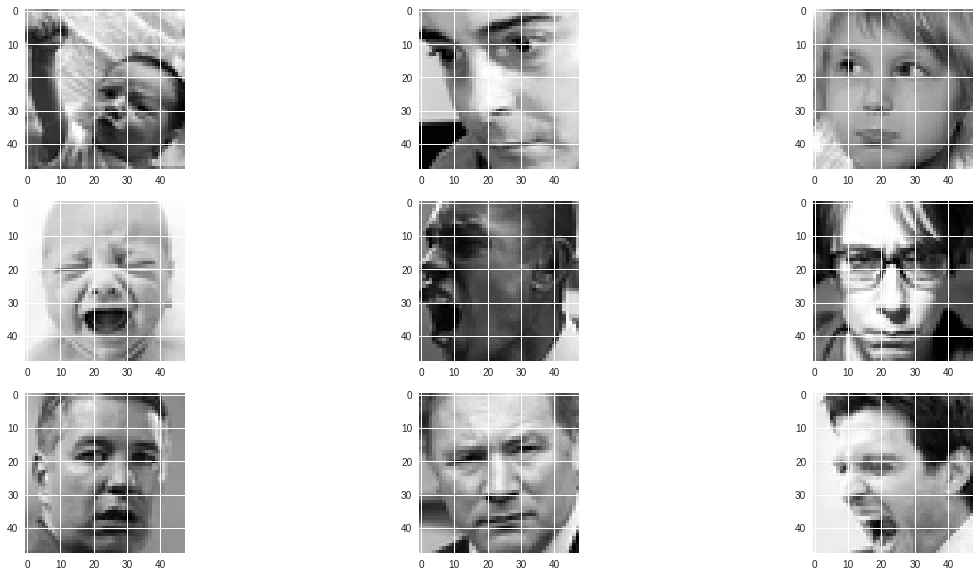

In [0]:
plot_examples(0)

Images belonging to class: Disgust


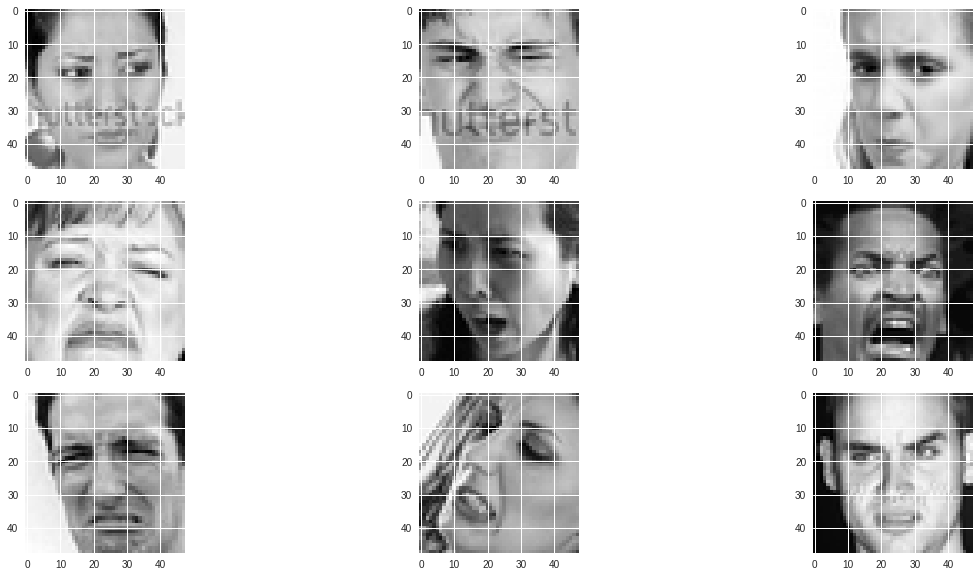

In [0]:
plot_examples(1)

Images belonging to class: Fear


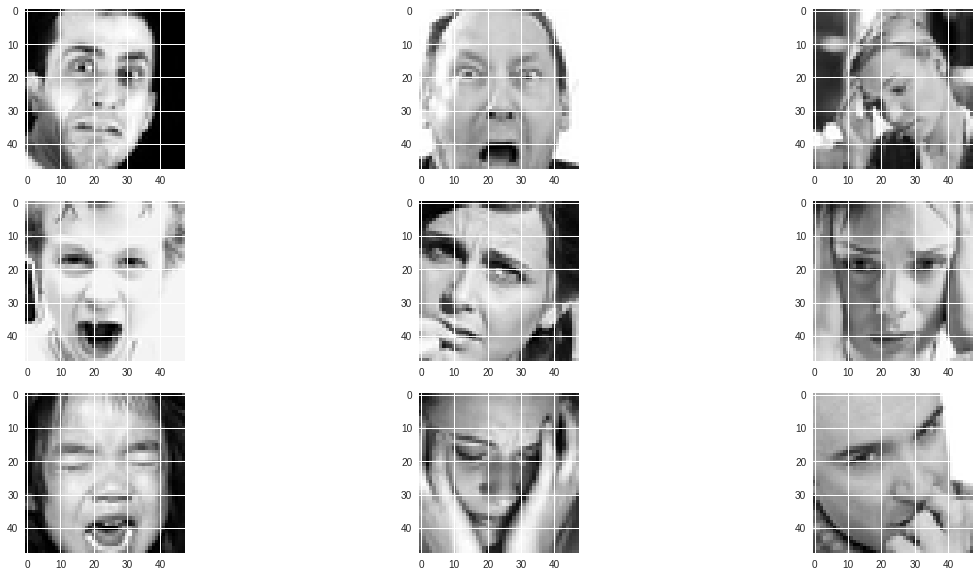

In [0]:
plot_examples(2)

Images belonging to class: Happy


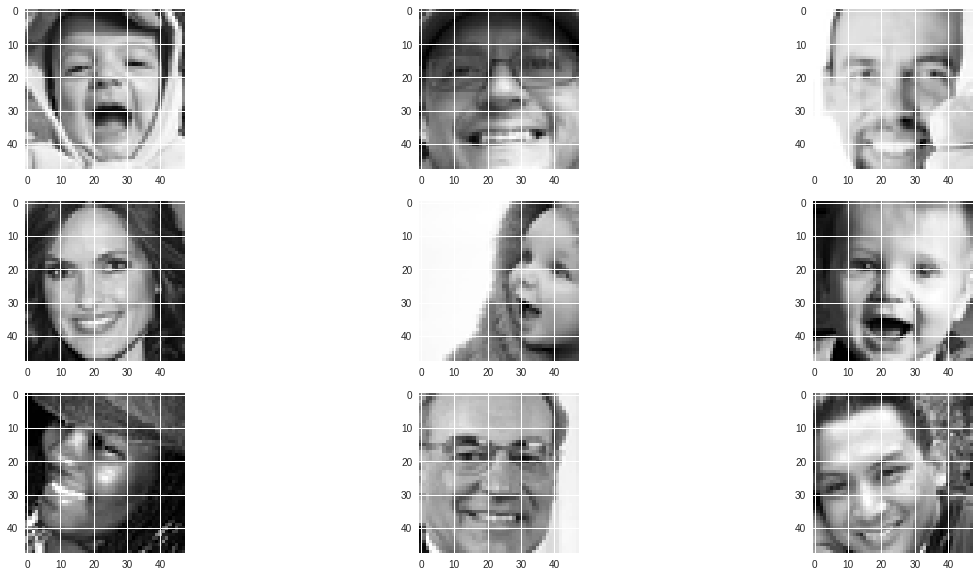

In [0]:
plot_examples(3)

Images belonging to class: Sad


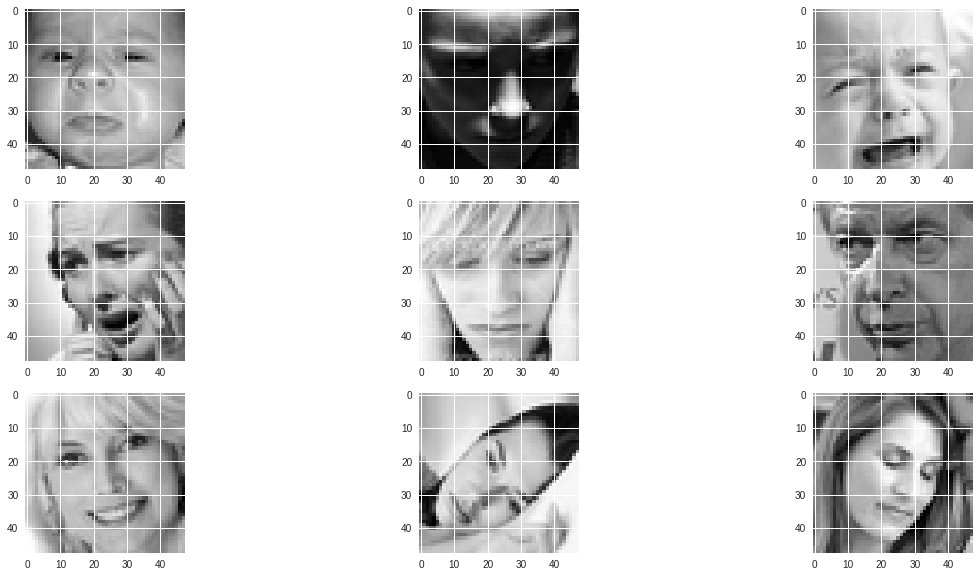

In [0]:
plot_examples(4)

Images belonging to class: Surprise


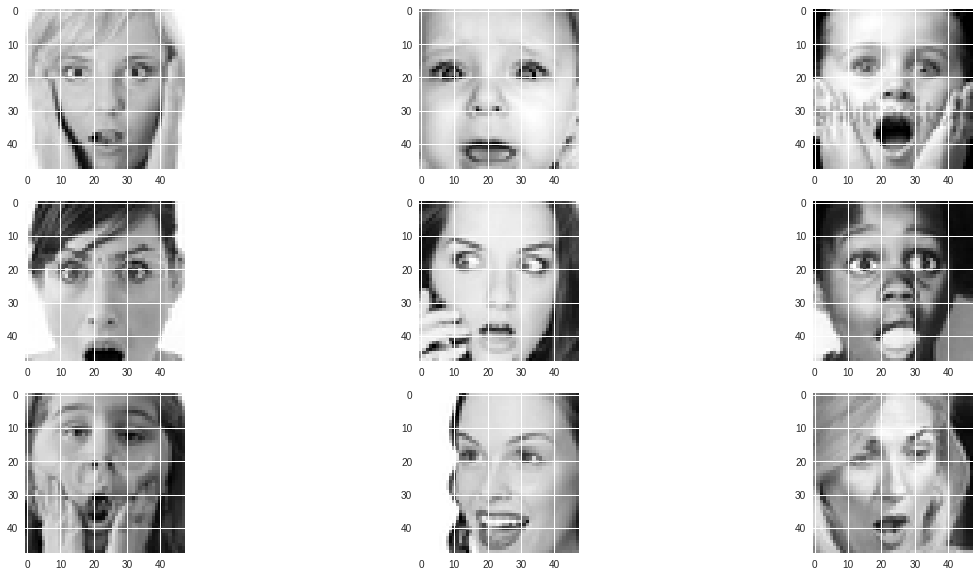

In [0]:
plot_examples(5)

Images belonging to class: Neutral


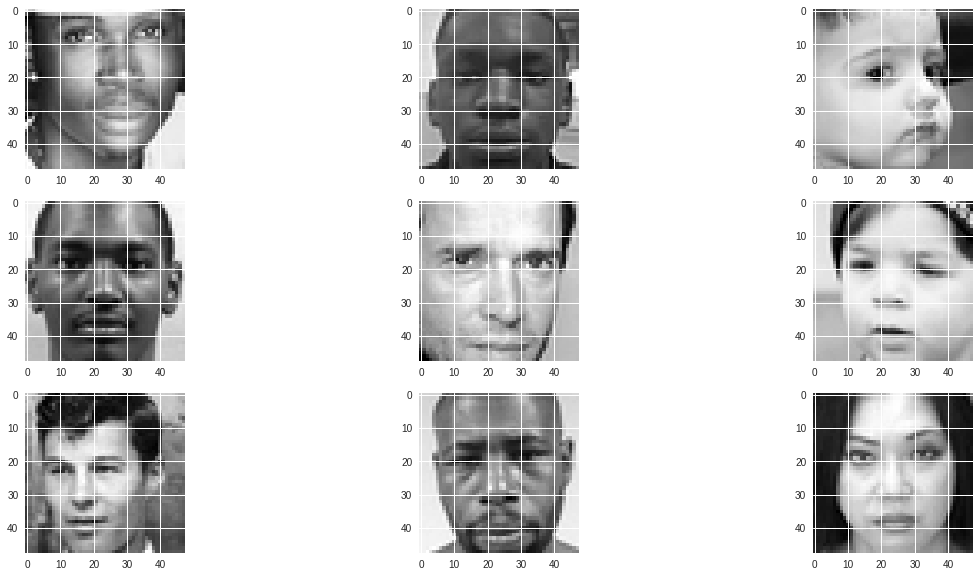

In [0]:
plot_examples(6)

#### 3.2 Loading and processing jaffe data

Each jaffe image has its label incorporated in its file name.
Let's load the file names and explore the different expressions

In [0]:
paths_jaffe = sorted(glob.glob('/content/data/jaffe/*.tiff'))

In [0]:
print('Number of images: {}'.format(len(paths_jaffe)))

Number of images: 213


In [0]:
# get the labels
jaffe_labels = np.array([im.split('.')[1][:2] for im in paths_jaffe])

In [0]:
print('frequency for each expression')
unique, counts = np.unique(jaffe_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

frequency for each expression
[['AN' '30']
 ['DI' '29']
 ['FE' '32']
 ['HA' '31']
 ['NE' '30']
 ['SA' '31']
 ['SU' '30']]


Let's create a function that read a tiff file and returns its numpy representation along with its label.

jaffe image label is incorporated in the file name

In [0]:
def load_tiff_image(path):
    dict_label = {
        0: 'AN',
        1: 'DI',
        2: 'FE',
        3: 'HA',
        4: 'SA',
        5: 'SU',
        6: 'NE'
    }
    rev_dict = dict([(v, k) for k, v in dict_label.items()])
    
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = rev_dict[path.split('.')[1][:2]]
    
    return (im, label)

In [0]:
jaffe_data = [load_tiff_image(p) for p in tqdm.tqdm(paths_jaffe)]
jaffe_array = np.concatenate([np.expand_dims(item[0], 0) for item in jaffe_data])
jaffe_labels = np.array([item[1] for item in jaffe_data])

100%|██████████| 213/213 [00:00<00:00, 2700.47it/s]


In [0]:
assert len(jaffe_array) == len(jaffe_labels)
print('jaffe data shape', jaffe_array.shape, jaffe_labels.shape)

jaffe data shape (213, 256, 256) (213,)


In [0]:
def plot_jaffe(label):
    dict_label = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    print('Images belonging to class:', dict_label[label])
    inds = np.where(jaffe_labels==label)[0]
    sample_inds = np.random.choice(inds, 9, replace=False)
    
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20,10))
    ax = ax.ravel()
    for idx, e in enumerate(sample_inds):
        img = jaffe_array[e]
        ax[idx].imshow(img, cmap='gray')

Images belonging to class: Angry


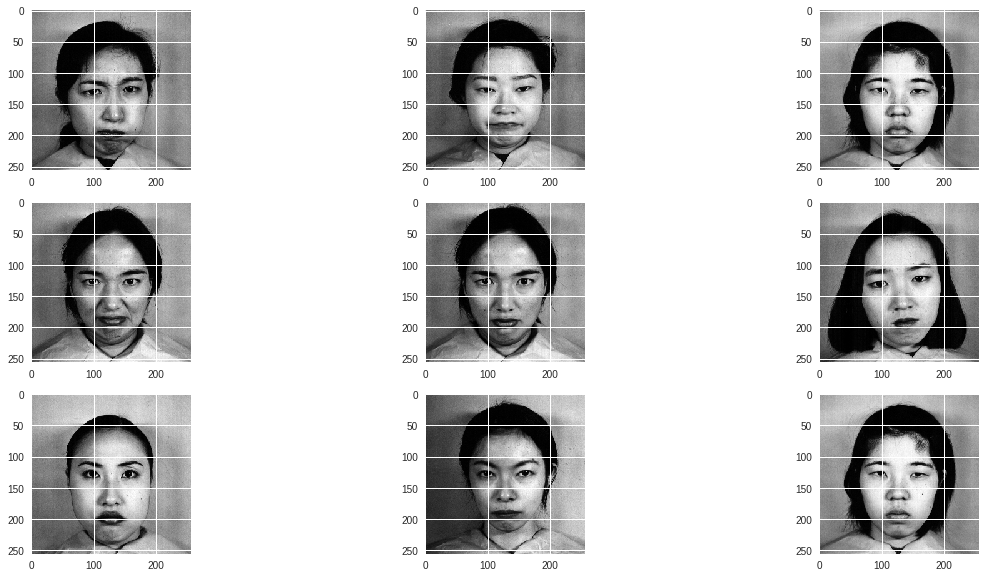

In [0]:
plot_jaffe(0)

Images belonging to class: Disgust


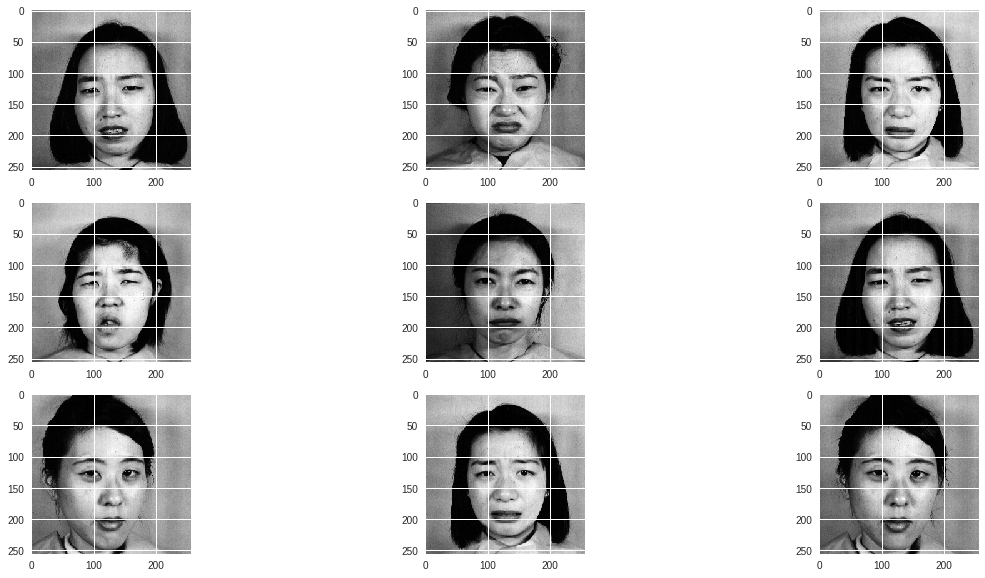

In [0]:
plot_jaffe(1)

Images belonging to class: Fear


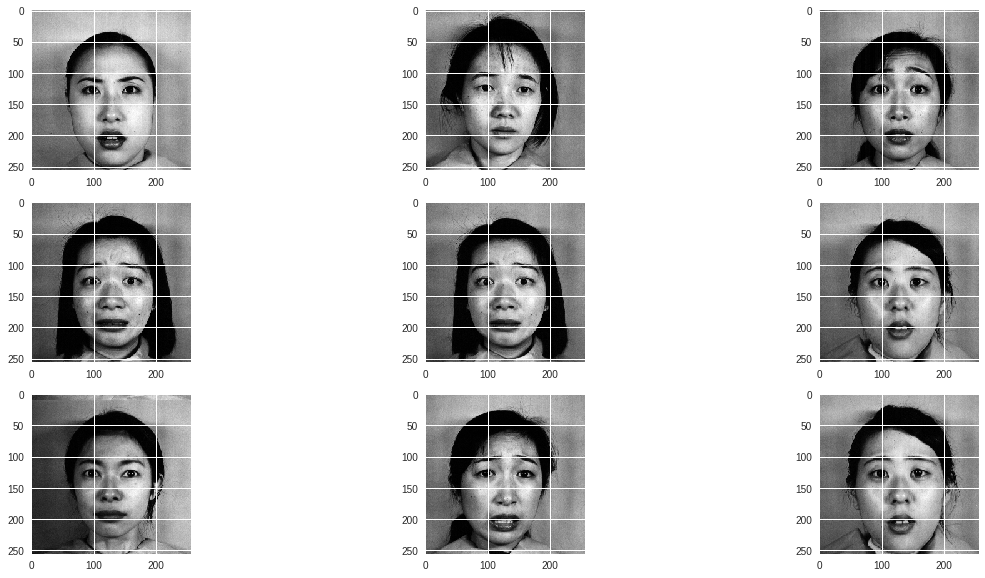

In [0]:
plot_jaffe(2)

Images belonging to class: Happy


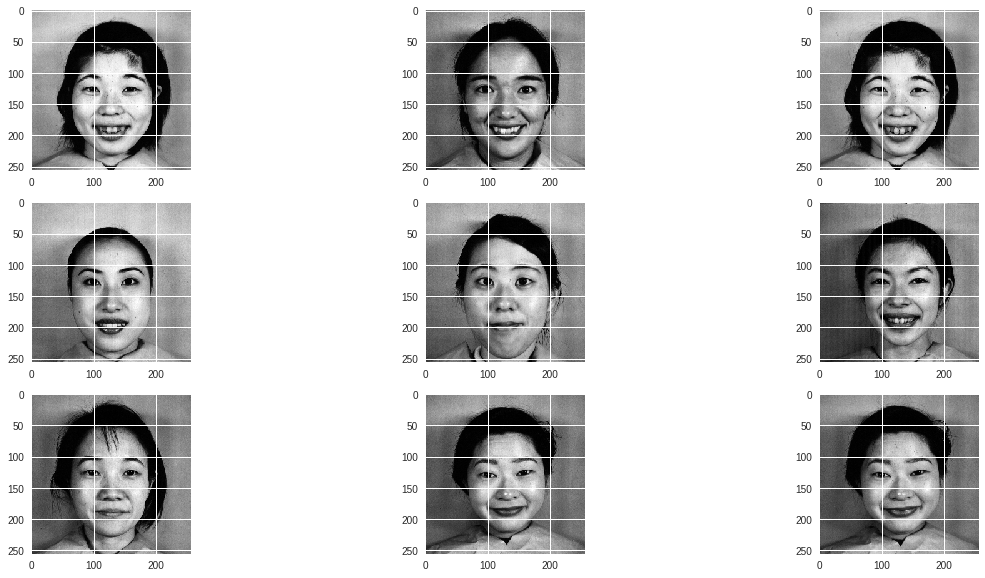

In [0]:
plot_jaffe(3)

Images belonging to class: Sad


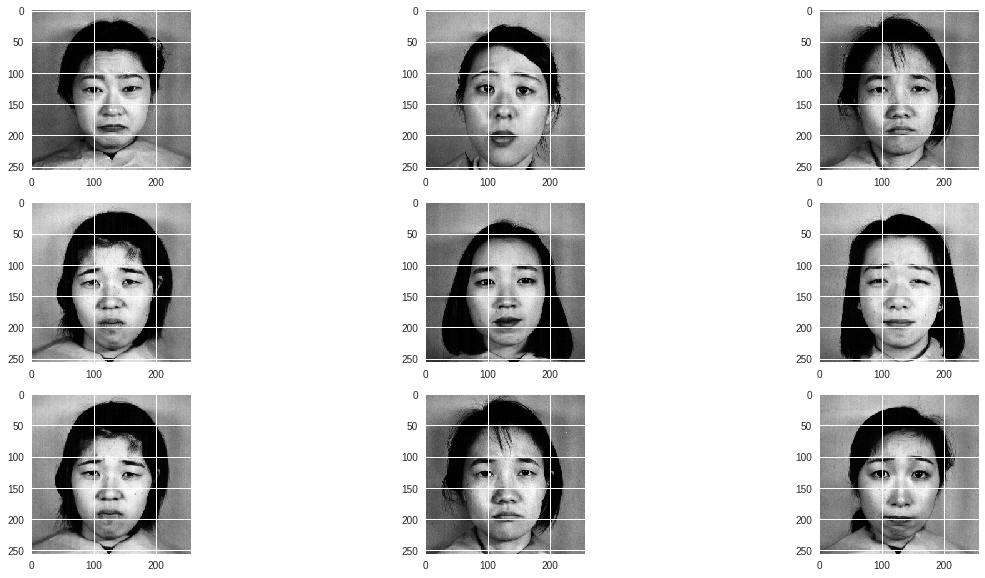

In [0]:
plot_jaffe(4)

Images belonging to class: Surprise


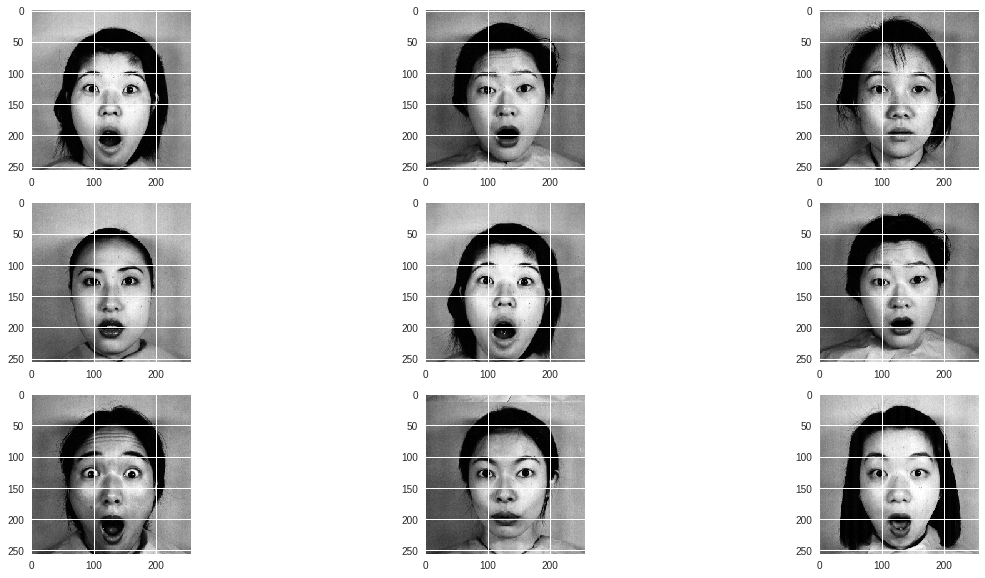

In [0]:
plot_jaffe(5)

Images belonging to class: Neutral


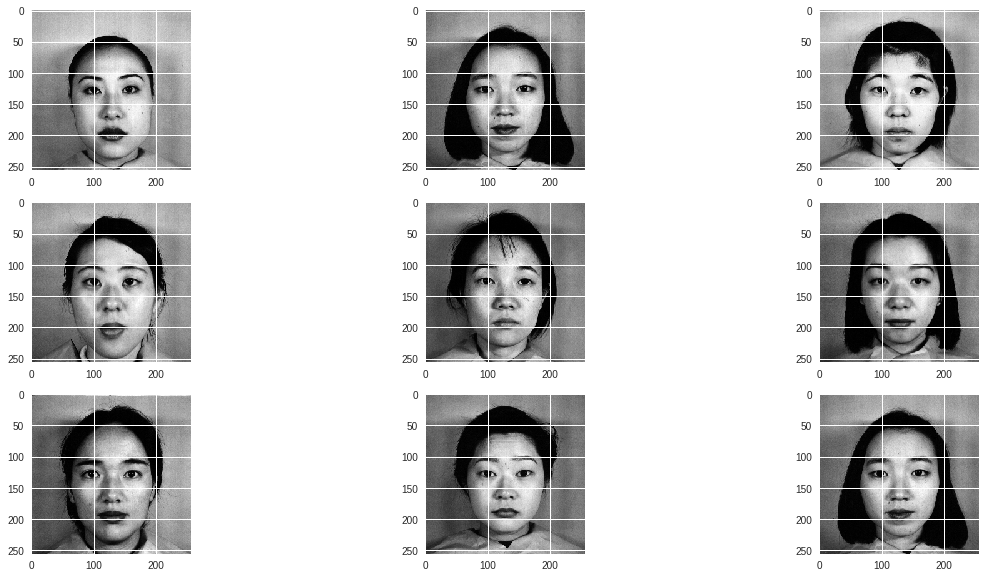

In [0]:
plot_jaffe(6)

#### 3.3 Further processing steps:
* face alignement
* image cropping
* image resizing

Define a function that applies all these prcessing steps to an image

In [0]:
# download the pretrained face_detector file for dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P /content/data

--2018-10-22 21:01:32--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/data/shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  23.2MB/s    in 2.6s    

2018-10-22 21:01:35 (23.2 MB/s) - ‘/content/data/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [0]:
!bzip2 -dk /content/data/shape_predictor_68_face_landmarks.dat.bz2

In [0]:
PATH_DETECTOR = '/content/data/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PATH_DETECTOR)

In [0]:
# function to align faces and compute landmarks
def align_and_crop(list_images, desiredFaceWidth=256, convert=True, resize=(800, 800)):
    
    # converting image to 8-bit
    if convert:
        print('--------------Converting images----------------')
        list_images = list(np.uint8(list_images))
    #resizing the  images
    if resize:
        print('--------------Resizing images----------------')
        #list_images = [transform.resize(np.repeat(np.expand_dims(im, 2), 3, 2), resize).astype('float32')
        #               for im in list_images]
        list_images = [np.repeat(np.expand_dims(im, 2), 3, 2) 
                       for im in list_images]
        
    # list_images = list(list_images)
    

    
    results = []
    print('----------------- Face alignment-------------------')
    for im in list_images:
        gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        # detect the face in the image
        rects = detector(gray, 2)
        if len(rects) > 0: # if we have at least one face detected
            rects = rects[0] # consider the 1st face
            faceAligned = fa.align(im, gray, rects) # align the face
            
            # cropping the image
            gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
            rects = detector(faceAligned, 2)
            if len(rects) > 0:
                rects = rects[0]
                (x, y, w, h) = rect_to_bb(rects) # get the bounding box coordinates
                faceCropped = transform.resize(faceAligned[y: y + h, 
                                                     x: x + w, 0], (48, 48))
                # shape = imutils.face_utils.shape_to_np(predictor(faceAligned, rects))
                # compute the cropping coordinates
                # center = shape[27]
                # right_eye = np.mean(shape[42:48], axis=0).astype(int)
                # alpha = right_eye[0] - center[0]
                # new_x = np.floor(center[0] - 1.2 * alpha).astype(int)
                # new_y = np.floor(center[1] - 1.3 * alpha).astype(int)
                # new_w = np.ceil(2.4 * alpha).astype(int)
                # new_h = np.ceil(4.5 * alpha).astype(int)
                  
                # crop the face and resize image to 48x48
                # faceCropped = transform.resize(faceAligned[new_y: new_y + new_h, 
                #                                     new_x: new_x + new_w, 0], (48, 48))
                print('OK 1')
                results.append(faceCropped)
            else:
                print('OK 2')
                # if no face is found in the aligned face, return just a resized aligned face 48x48
                # results.append(transform.resize(faceAligned[:, :, 0], (48, 48)))
                results.append(faceAligned[:, :, 0])
        else:
            print('OK 3')
            # if no face is found at all in the image, return the resized original image 48x48
            # results.append(transform.resize(im[:, :, 0], (48, 48)))
            results.append(im[:, :, 0])
    
    # apply histogram equalization to all images and return the result
    return np.concatenate(
        [np.expand_dims(exposure.equalize_hist(item), 0) for item in results]
    )


In [0]:
# Instanciate a face aligner object
fa = FaceAligner(predictor, desiredFaceWidth=48)

# function to process one image
def align_and_crop_one(im):

    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # detect the face in the image
    rects = detector(gray, 2)
    if len(rects) > 0: # if we have at least one face detected
        rects = rects[0] # consider the 1st face
        faceAligned = fa.align(im, gray, rects) # align the face

        # cropping the image
        gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        rects = detector(faceAligned, 2)
        if len(rects) > 0:
            rects = rects[0]
            (x, y, w, h) = rect_to_bb(rects) # get the bounding box coordinates
            faceCropped = transform.resize(faceAligned[y: y + h, 
                                                 x: x + w, 0], (48, 48))

            # print('OK 1')
            return (exposure.equalize_hist(faceCropped), 'OK1')
        else:
            # print('OK 2')
            # if no face is found in the aligned face, return just a resized aligned face 48x48
            return (exposure.equalize_hist(faceAligned[:, :, 0]), 'OK2')
    else:
        # print('OK 3')
        # if no face is found at all in the image, return the resized original image 48x48
        return (exposure.equalize_hist(transform.resize(im[:, :, 0], (48, 48))), 'OK3')


# function to align faces and compute landmarks
def align_and_crop(list_images, convert=True, reshape=True):
    # converting image to 8-bit
    if convert:
        print('--------------Converting images----------------')
        list_images = list(np.uint8(list_images))
    #resizing the  images
    if reshape:
        print('--------------Resizing images----------------')
        list_images = [np.repeat(np.expand_dims(im, 2), 3, 2) 
                       for im in list_images]
    
    with Pool() as p:
        results_tuple = p.map(align_and_crop_one, tqdm.tqdm(list_images))
    
    results1 = [item[0] for item in results_tuple]
    results2 = [item[1] for item in results_tuple]
    
    # apply histogram equalization to all images and return the result
    return np.concatenate([np.expand_dims(item, 0) for item in results1]), dict(Counter(results2))


In [0]:
%%time
fer2013_transformed, counts = align_and_crop(fer2013_array)

--------------Converting images----------------
--------------Resizing images----------------


100%|██████████| 35887/35887 [08:40<00:00, 68.92it/s]


CPU times: user 3.14 s, sys: 1.94 s, total: 5.08 s
Wall time: 11min 38s


In [0]:
%%time
jaffe_transformed, counts_j = align_and_crop(jaffe_array)

--------------Converting images----------------
--------------Resizing images----------------


100%|██████████| 213/213 [00:22<00:00,  9.48it/s]


CPU times: user 290 ms, sys: 172 ms, total: 462 ms
Wall time: 30.2 s


Save the data to gdrive

In [0]:
#path to Google Drive
PATH_DRIVE = '/content/gdrive/My Drive/Face_detection'


In [0]:
%%time

np.save(os.path.join(PATH_DRIVE, 'fer2013_transformed.npy'), fer2013_transformed)
np.save(os.path.join(PATH_DRIVE, 'fer2013_labels.npy'), fer2013_labels)
np.save(os.path.join(PATH_DRIVE, 'fer2013_array.npy'), fer2013_array)
np.save(os.path.join(PATH_DRIVE, 'flags.npy'), flags)

np.save(os.path.join(PATH_DRIVE, 'jaffe_array.npy'), jaffe_array)
np.save(os.path.join(PATH_DRIVE, 'jaffe_labels.npy'), jaffe_labels)
np.save(os.path.join(PATH_DRIVE, 'jaffe_transformed.npy'), jaffe_transformed)

CPU times: user 71.7 ms, sys: 829 ms, total: 901 ms
Wall time: 8.41 s


### 4. Modeling phase

In [0]:
%%time

# Load the data from drive
PATH_DRIVE = '/content/gdrive/My Drive/Face_detection'

fer2013_transformed = np.load(os.path.join(PATH_DRIVE, 'fer2013_transformed.npy'))
fer2013_labels = np.load(os.path.join(PATH_DRIVE, 'fer2013_labels.npy'))
fer2013_array = np.load(os.path.join(PATH_DRIVE, 'fer2013_array.npy'))
flags = np.load(os.path.join(PATH_DRIVE, 'flags.npy'))

jaffe_array = np.load(os.path.join(PATH_DRIVE, 'jaffe_array.npy'))
jaffe_labels = np.load(os.path.join(PATH_DRIVE, 'jaffe_labels.npy'))
jaffe_transformed = np.load(os.path.join(PATH_DRIVE, 'jaffe_transformed.npy'))

CPU times: user 3.19 ms, sys: 1.15 s, total: 1.16 s
Wall time: 2.33 s


#### 4.1 Data preparation

Create train - validation - test sets

In [0]:
# train set
train_fer2013_images = fer2013_transformed[np.where(flags=='Training')[0]]
train_fer2013_labels = fer2013_labels[np.where(flags=='Training')[0]]

# validation set
val_fer2013_images = fer2013_transformed[np.where(flags=='PublicTest')[0]]
val_fer2013_labels = fer2013_labels[np.where(flags=='PublicTest')[0]]

# test set
test_fer2013_images = fer2013_transformed[np.where(flags=='PrivateTest')[0]]
test_fer2013_labels = fer2013_labels[np.where(flags=='PrivateTest')[0]]

In [0]:
print(train_fer2013_images.shape, train_fer2013_labels.shape)
print(val_fer2013_images.shape, val_fer2013_labels.shape)
print(test_fer2013_images.shape, test_fer2013_labels.shape)

(28709, 48, 48) (28709,)
(3589, 48, 48) (3589,)
(3589, 48, 48) (3589,)


In [0]:
def plot_images(images, labels, class_):
    dict_label = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    print('Images belonging to class:', dict_label[class_])
    inds = np.where(labels==class_)[0]
    sample_inds = np.random.choice(inds, 16, replace=False)
    
    fig, ax = plt.subplots(nrows=4,ncols=4,figsize=(22,10))
    ax = ax.ravel()
    for idx, e in enumerate(sample_inds):
        img = images[e]
        ax[idx].imshow(img, cmap='gray')

Images belonging to class: Neutral


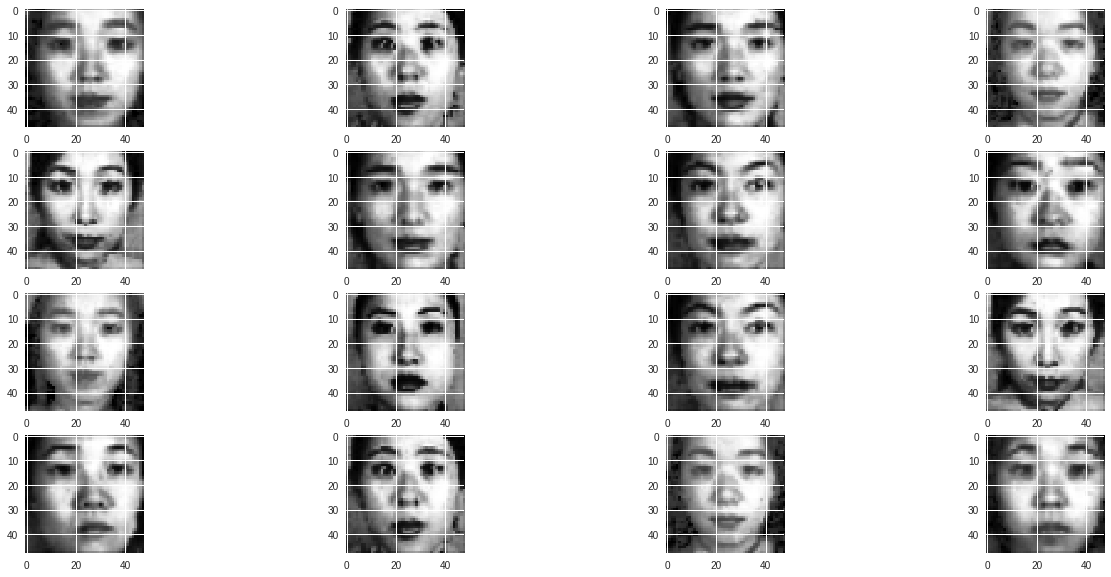

In [0]:
plot_images(jaffe_transformed, jaffe_labels, 6)

Now we concatenate fer2013 data and jaffe

In [0]:
train_images = np.concatenate([train_fer2013_images, jaffe_transformed])
train_labels = np.concatenate([train_fer2013_labels, jaffe_labels])

In [0]:
print(train_images.shape, train_labels.shape)
print(val_fer2013_images.shape, val_fer2013_labels.shape)
print(test_fer2013_images.shape, test_fer2013_labels.shape)

(28922, 48, 48) (28922,)
(3589, 48, 48) (3589,)
(3589, 48, 48) (3589,)


In [ ]:
# Let's create a pytorch dataset class
1+1

In [0]:
class FaceData(Dataset):
    """Face image dataset."""
    
    def __init__(self, images, labels, transform=None):
        assert images.shape[0] == labels.shape[0]
        self.images = images
        self.labels = np.expand_dims(labels, 1)
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        sample = (np.expand_dims(self.images[idx], 0), self.labels[idx])
        if self.transform:
            sample = self.transform(sample)
        return sample

# Transformer to convert numpy into pytorch tensor
class ToTensor(object):
    def __call__(self, sample):
        return (torch.from_numpy(sample[0]), torch.from_numpy(sample[1]))

In [0]:
# Define some constants
N_EPOCHS = 25
BATCH_SIZE = 128

In [0]:
# Instanciate a transform object
list_transforms = transforms.Compose([ToTensor()])

# Create train, test and validation data objects
face_datasets = {
    'train': FaceData(train_images, train_labels, list_transforms),
    'val': FaceData(val_fer2013_images, val_fer2013_labels, list_transforms),
}

face_datasets_test = FaceData(test_fer2013_images, test_fer2013_labels, list_transforms)

# Data loaders
dataloaders = {
    phase: DataLoader(face_datasets[phase], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for phase in ['train', 'val']
}
dataset_sizes = {phase: len(face_datasets[phase]) for phase in ['train', 'val']}

dataloaders_test = DataLoader(face_datasets_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataset_sizes_test = len(face_datasets_test)

In [0]:
# check if train data loader is OK
tmp = next(iter(dataloaders['train']))
print(tmp[0].size())
print(tmp[1].size())

torch.Size([128, 1, 48, 48])
torch.Size([128, 1])


In [0]:
# check if validation data loader is OK
tmp = next(iter(dataloaders['val']))
print(tmp[0].size())
print(tmp[1].size())

torch.Size([128, 1, 48, 48])
torch.Size([128, 1])


In [0]:
# check if test data loader is OK
tmp = next(iter(dataloaders_test))
print(tmp[0].size())
print(tmp[1].size())

torch.Size([128, 1, 48, 48])
torch.Size([128, 1])


In [0]:
print(tmp[0].dtype)
print(tmp[1].dtype)

torch.float64
torch.int64


#### 4.2 Create a model

We'll implement a depthwise separable convolution network

Depthwise separable conv layer

In [0]:
class SeparableConv(torch.nn.Module):
    """Depthwise separable convolution layer implementation."""
    
    def __init__(self, nin, nout, kernel_size=3):
        super(SeparableConv, self).__init__()
        self.depthwise = torch.nn.Conv2d(nin, nin, kernel_size=kernel_size, groups=nin)
        self.pointwise = torch.nn.Conv2d(nin, nout, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [0]:
class Model(torch.nn.Module):
    
    def __init__(self, dropout=0.3, n_class=7, n_filters=[64, 128, 256, 512]):
        super(Model, self).__init__()
        
        self.dropout = dropout
        self.n_class = n_class
        self.n_filters = n_filters
        
        # 1st block
        self.conv1 = SeparableConv(1, self.n_filters[0])
        self.batchnorm1 = torch.nn.BatchNorm2d(self.n_filters[0])
        self.conv2 = SeparableConv(self.n_filters[0], self.n_filters[0])
        self.batchnorm2 = torch.nn.BatchNorm2d(self.n_filters[0])
        
        # 2nd block
        self.conv3 = SeparableConv(self.n_filters[0], self.n_filters[1])
        self.batchnorm3 = torch.nn.BatchNorm2d(self.n_filters[1])
        self.conv4 = SeparableConv(self.n_filters[1], self.n_filters[1])
        self.batchnorm4 = torch.nn.BatchNorm2d(self.n_filters[1])
        
        # 3rd block
        self.conv5 = SeparableConv(self.n_filters[1], self.n_filters[2])
        self.batchnorm5 = torch.nn.BatchNorm2d(self.n_filters[2])
        self.conv6 = SeparableConv(self.n_filters[2], self.n_filters[2])
        self.batchnorm6 = torch.nn.BatchNorm2d(self.n_filters[2])
        
        # 4th block
        self.conv7 = SeparableConv(self.n_filters[2], self.n_filters[3])
        self.batchnorm7 = torch.nn.BatchNorm2d(self.n_filters[3])
        self.conv8 = SeparableConv(self.n_filters[3], self.n_filters[3])
        self.batchnorm8 = torch.nn.BatchNorm2d(self.n_filters[3])
        
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        # 1st fc block
        self.fc1 = torch.nn.Linear(self.n_filters[3], 256)
        self.batchnorm9 = torch.nn.BatchNorm1d(256)
        
         # 2nd fc block
        self.fc2 = torch.nn.Linear(256, 128)
        self.batchnorm10 = torch.nn.BatchNorm1d(128)
        
         # output block
        self.fc3 = torch.nn.Linear(128, self.n_class)
        
    def forward(self, x):
        #1st block
        x = self.conv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        x = F.max_pool2d(x, 2)
        
        # 2nd block
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        x = F.max_pool2d(x, 2)
        
        # 3rd block
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        x = self.conv6(x)
        x = F.relu(self.batchnorm6(x))
        # x = F.max_pool2d(x, 2)
                
        # 4th block
        x = self.conv7(x)
        x = F.relu(self.batchnorm7(x))
        x = self.conv8(x)
        x = F.relu(self.batchnorm8(x))
        # x = F.max_pool2d(x, 2)
        
        x = self.avg_pool(x)
        x = F.dropout(x.view(-1, x.size()[1]), self.dropout)
        
        x = F.relu(self.batchnorm9(self.fc1(x)))
        x = F.dropout(x, self.dropout)
        
        x = F.relu(self.batchnorm10(self.fc2(x)))
        x = F.dropout(x, self.dropout)
        
        x = self.fc3(x)
        
        return x


#### 4. 3 Training phase

In [0]:
# check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
# instantiate model and optimizers
model = Model()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
print(model)

Model(
  (conv1): SeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (pointwise): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64)
    (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64)
    (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SeparableConv(
    (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), groups=128)
    (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (batchnorm

In [0]:
# utility function to get the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
print('Number of trainable paramaters: {}'.format(count_parameters(model)))

Number of trainable paramaters: 706001


Let's create a training utility function

In [0]:
def train_model(model, criterion, optimizer, data=dataloaders, dataset_sizes=dataset_sizes, num_epochs=N_EPOCHS):
    since = time.time()
    acc_history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluation mode
        
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in data[phase]:
                # inputs = inputs.to(device, dtype=torch.float)
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.view(labels.size()[0]).to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            acc_history[phase].append(epoch_acc.to('cpu').numpy().mean()) 
            loss_history[phase].append(epoch_loss) 
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            # deep copy th emodel
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history


In [0]:
# helper plot function to plot the training history
def plot_train_history(accuracies, losses):
    acc = accuracies['train']
    val_acc = accuracies['val']
    loss = losses['train']
    val_loss = losses['val']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [0]:
# start training
model, accuracies, losses = train_model(model, criterion, optimizer)

Epoch 1/25
----------
train Loss: 1.5388, Acc: 0.4021
val Loss: 1.4004, Acc: 0.4673

Epoch 2/25
----------
train Loss: 1.3129, Acc: 0.5010
val Loss: 1.3344, Acc: 0.4890

Epoch 3/25
----------
train Loss: 1.2051, Acc: 0.5481
val Loss: 1.2736, Acc: 0.5244

Epoch 4/25
----------
train Loss: 1.1110, Acc: 0.5878
val Loss: 1.2840, Acc: 0.5258

Epoch 5/25
----------
train Loss: 1.0172, Acc: 0.6228
val Loss: 1.2364, Acc: 0.5344

Epoch 6/25
----------
train Loss: 0.9232, Acc: 0.6630
val Loss: 1.2766, Acc: 0.5383

Epoch 7/25
----------
train Loss: 0.8177, Acc: 0.7034
val Loss: 1.3510, Acc: 0.5425

Epoch 8/25
----------
train Loss: 0.7206, Acc: 0.7440
val Loss: 1.4047, Acc: 0.5414

Epoch 9/25
----------
train Loss: 0.6268, Acc: 0.7765
val Loss: 1.4299, Acc: 0.5405

Epoch 10/25
----------
train Loss: 0.5431, Acc: 0.8095
val Loss: 1.5075, Acc: 0.5411

Epoch 11/25
----------
train Loss: 0.4648, Acc: 0.8378
val Loss: 1.6146, Acc: 0.5339

Epoch 12/25
----------
train Loss: 0.4043, Acc: 0.8633
val Loss

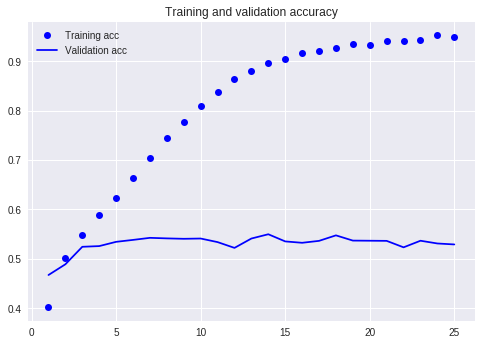

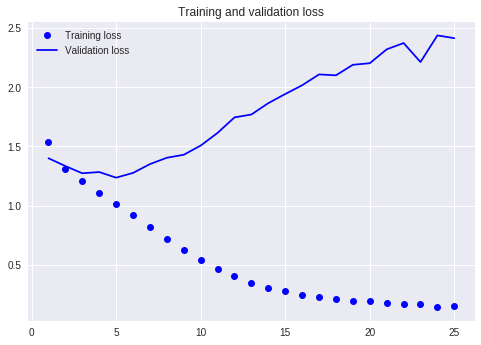

In [0]:
plot_train_history(accuracies, losses)

Clearly the model is overfitting, let's increase dropout rate from 30 to 70%:

In [0]:
# instantiate model and optimizers
model2 = Model(0.7)
model2 = model2.to(device)
criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters())

In [0]:
# start training
model2, accuracies2, losses2 = train_model(model2, criterion2, optimizer2, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.7510, Acc: 0.2933
val Loss: 1.5690, Acc: 0.3761

Epoch 2/50
----------
train Loss: 1.5131, Acc: 0.4157
val Loss: 1.4644, Acc: 0.4327

Epoch 3/50
----------
train Loss: 1.3919, Acc: 0.4700
val Loss: 1.4292, Acc: 0.4383

Epoch 4/50
----------
train Loss: 1.3207, Acc: 0.4981
val Loss: 1.3535, Acc: 0.4845

Epoch 5/50
----------
train Loss: 1.2550, Acc: 0.5276
val Loss: 1.3276, Acc: 0.4996

Epoch 6/50
----------
train Loss: 1.2001, Acc: 0.5500
val Loss: 1.3269, Acc: 0.5116

Epoch 7/50
----------
train Loss: 1.1446, Acc: 0.5757
val Loss: 1.3266, Acc: 0.5174

Epoch 8/50
----------
train Loss: 1.0779, Acc: 0.6007
val Loss: 1.3260, Acc: 0.5127

Epoch 9/50
----------
train Loss: 1.0237, Acc: 0.6233
val Loss: 1.4150, Acc: 0.5043

Epoch 10/50
----------
train Loss: 0.9501, Acc: 0.6553
val Loss: 1.4122, Acc: 0.5166

Epoch 11/50
----------
train Loss: 0.9031, Acc: 0.6732
val Loss: 1.4257, Acc: 0.5074

Epoch 12/50
----------
train Loss: 0.8271, Acc: 0.7060
val Loss

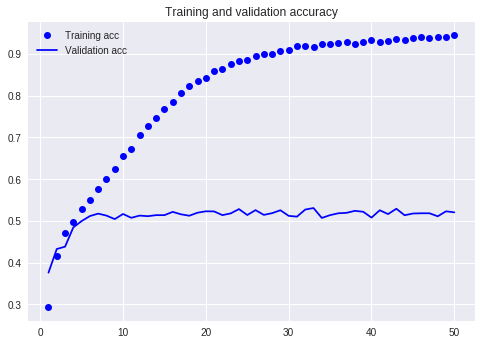

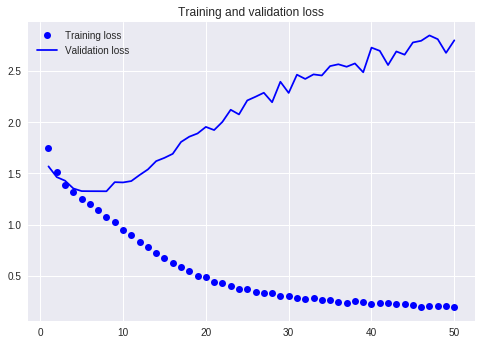

In [0]:
plot_train_history(accuracies2, losses2)

The model is still overfitting, let's add L2 regularization to model's weights

In [0]:
# instantiate model and optimizers
model3 = Model(0.7)
model3 = model3.to(device)
criterion3 = torch.nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=1e-2, weight_decay=5e-4)

In [0]:
model3, accuracies3, losses3 = train_model(model3, criterion3, optimizer3, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.7368, Acc: 0.2961
val Loss: 1.6470, Acc: 0.3455

Epoch 2/50
----------
train Loss: 1.6244, Acc: 0.3524
val Loss: 1.6135, Acc: 0.3483

Epoch 3/50
----------
train Loss: 1.5873, Acc: 0.3676
val Loss: 1.6440, Acc: 0.3748

Epoch 4/50
----------
train Loss: 1.5651, Acc: 0.3734
val Loss: 1.8237, Acc: 0.3422

Epoch 5/50
----------
train Loss: 1.5547, Acc: 0.3796
val Loss: 1.5490, Acc: 0.3906

Epoch 6/50
----------
train Loss: 1.5491, Acc: 0.3834
val Loss: 1.5271, Acc: 0.3979

Epoch 7/50
----------
train Loss: 1.5302, Acc: 0.3913
val Loss: 1.5641, Acc: 0.3745

Epoch 8/50
----------
train Loss: 1.5265, Acc: 0.3925
val Loss: 1.5388, Acc: 0.3789

Epoch 9/50
----------
train Loss: 1.5190, Acc: 0.3973
val Loss: 1.6129, Acc: 0.3644

Epoch 10/50
----------
train Loss: 1.5292, Acc: 0.3865
val Loss: 1.5353, Acc: 0.3982

Epoch 11/50
----------
train Loss: 1.5189, Acc: 0.3941
val Loss: 1.6008, Acc: 0.3466

Epoch 12/50
----------
train Loss: 1.5170, Acc: 0.3961
val Loss

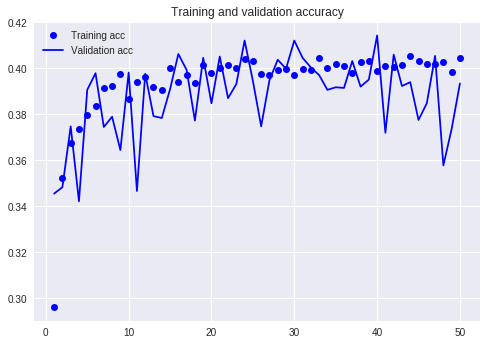

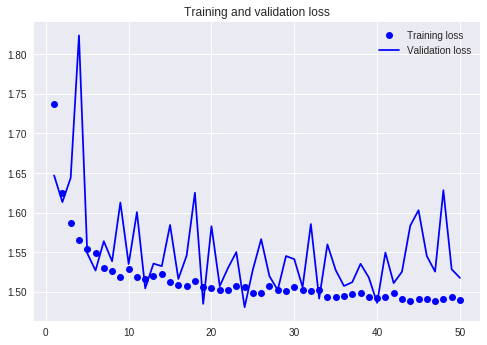

In [0]:
plot_train_history(accuracies3, losses3)

In [0]:
# instantiate model and optimizers
model4 = Model(0.7)
model4 = model4.to(device)
criterion4 = torch.nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), weight_decay=5e-4)

In [0]:
model4, accuracies4, losses4 = train_model(model4, criterion4, optimizer4, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.7482, Acc: 0.2880
val Loss: 1.5917, Acc: 0.3714

Epoch 2/50
----------
train Loss: 1.5161, Acc: 0.4100
val Loss: 1.4923, Acc: 0.4224

Epoch 3/50
----------
train Loss: 1.3912, Acc: 0.4691
val Loss: 1.3908, Acc: 0.4684

Epoch 4/50
----------
train Loss: 1.3113, Acc: 0.5022
val Loss: 1.3542, Acc: 0.4876

Epoch 5/50
----------
train Loss: 1.2583, Acc: 0.5264
val Loss: 1.3504, Acc: 0.5007

Epoch 6/50
----------
train Loss: 1.2173, Acc: 0.5415
val Loss: 1.3555, Acc: 0.5024

Epoch 7/50
----------
train Loss: 1.1790, Acc: 0.5581
val Loss: 1.2931, Acc: 0.5166

Epoch 8/50
----------
train Loss: 1.1442, Acc: 0.5753
val Loss: 1.3587, Acc: 0.5032

Epoch 9/50
----------
train Loss: 1.1018, Acc: 0.5921
val Loss: 1.3334, Acc: 0.5188

Epoch 10/50
----------
train Loss: 1.0584, Acc: 0.6137
val Loss: 1.2895, Acc: 0.5288

Epoch 11/50
----------
train Loss: 1.0315, Acc: 0.6237
val Loss: 1.3605, Acc: 0.5194

Epoch 12/50
----------
train Loss: 0.9968, Acc: 0.6386
val Loss

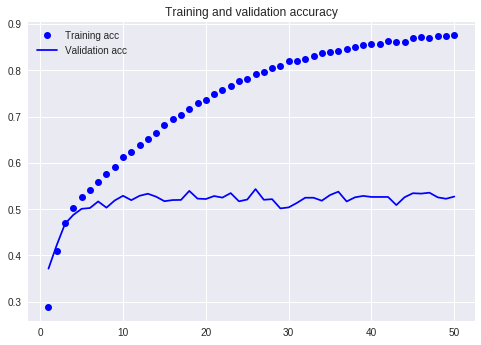

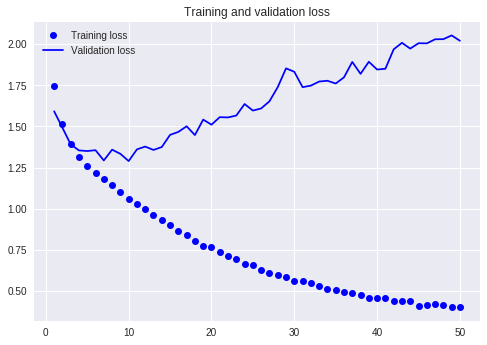

In [0]:
plot_train_history(accuracies4, losses4)

#### 4.4 Exploring model predictions

Validation accuracy is varying between 53-55%. Let's explore the predictions by the model to see where it is doing well and where it is failing

In [0]:
# an evaluation funtion

labels_ = [0, 1, 2, 3, 4, 5, 6]
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def evaluate_model(model=model, data=dataloaders['val'], 
                   title='Confusion matrix', normalize=False,
                  labels_=labels_, target_names=target_names):
    y_true = []
    y_pred = []
    
    # first, get the predictions
    model.eval() # set model in evaluation mode
    with torch.no_grad():
        # Iterate over data.
        for inputs, labels in data:
            # inputs = inputs.to(device, dtype=torch.float)
            inputs = inputs.to(device, dtype=torch.float)
            y_true.append(labels.squeeze(1))
            labels = labels.view(labels.size()[0]).to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.append(preds.to('cpu').numpy())
            
    # print classification report
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    print(classification_report(y_true, y_pred, labels=labels_, target_names=target_names))
    
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


             precision    recall  f1-score   support

      Angry       0.46      0.43      0.45       467
    Disgust       0.51      0.34      0.41        56
       Fear       0.40      0.38      0.39       496
      Happy       0.73      0.77      0.75       895
        Sad       0.41      0.40      0.41       653
   Surprise       0.70      0.67      0.69       415
    Neutral       0.46      0.51      0.49       607

avg / total       0.54      0.54      0.54      3589



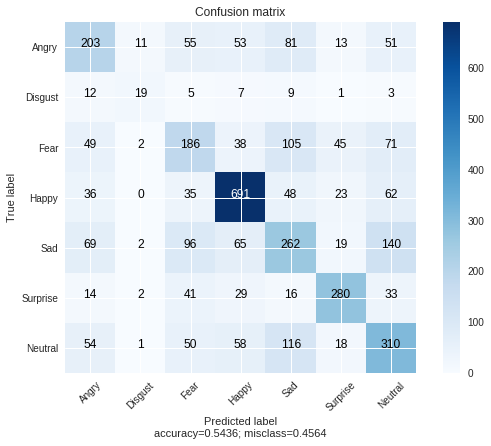

In [0]:
evaluate_model()

             precision    recall  f1-score   support

      Angry       0.45      0.42      0.43       467
    Disgust       0.00      0.00      0.00        56
       Fear       0.36      0.34      0.35       496
      Happy       0.73      0.77      0.75       895
        Sad       0.40      0.42      0.41       653
   Surprise       0.67      0.71      0.69       415
    Neutral       0.44      0.45      0.44       607

avg / total       0.52      0.53      0.52      3589



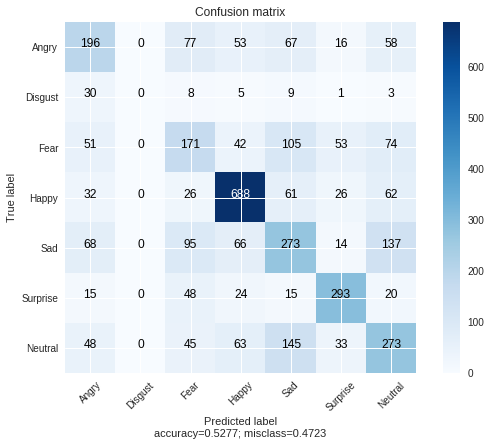

In [0]:
evaluate_model(model=model2)

             precision    recall  f1-score   support

      Angry       0.18      0.02      0.03       467
    Disgust       0.00      0.00      0.00        56
       Fear       0.21      0.14      0.16       496
      Happy       0.70      0.76      0.73       895
        Sad       0.26      0.54      0.35       653
   Surprise       0.67      0.54      0.60       415
    Neutral       0.26      0.24      0.25       607

avg / total       0.40      0.41      0.38      3589



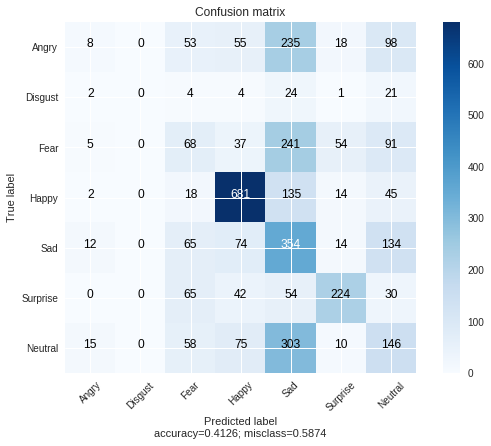

In [0]:
evaluate_model(model=model3)

             precision    recall  f1-score   support

      Angry       0.46      0.40      0.43       467
    Disgust       0.00      0.00      0.00        56
       Fear       0.36      0.34      0.35       496
      Happy       0.71      0.80      0.75       895
        Sad       0.41      0.41      0.41       653
   Surprise       0.68      0.69      0.68       415
    Neutral       0.49      0.51      0.50       607

avg / total       0.52      0.54      0.53      3589



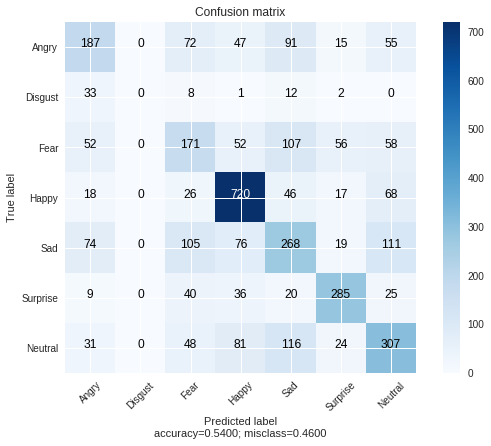

In [0]:
evaluate_model(model=model4)

In [0]:
# Let's save the trained models
if not os.path.exists('/content/gdrive/My Drive/Face_detection/phase_1'):
    os.mkdir('/content/gdrive/My Drive/Face_detection/phase_1')

PATH_TMP = '/content/gdrive/My Drive/Face_detection/phase_1'
model_names = ['model', 'model2', 'model3', 'model4']
list_models = [model, model2, model3, model4]
for i in range(len(list_models)):
    torch.save(list_models[i].state_dict(), os.path.join(PATH_TMP, model_names[i]+'.pth'))


From the above evaluations, we can see that the worst classes in terms of recall are "Disgust" and "Fear" . Let's remove these 2 classes and see How the model will perform better.

In [0]:
# remove Disgust and Fear classes
train_images_new = train_images[np.where((train_labels!=1) & (train_labels!=2))[0]]
train_labels_new = train_labels[np.where((train_labels!=1) & (train_labels!=2))[0]]

test_images_new = test_fer2013_images[np.where((test_fer2013_labels!=1) & (test_fer2013_labels!=2))[0]]
test_labels_new = test_fer2013_labels[np.where((test_fer2013_labels!=1) & (test_fer2013_labels!=2))[0]]

val_images_new = val_fer2013_images[np.where((val_fer2013_labels!=1) & (val_fer2013_labels!=2))[0]]
val_labels_new = val_fer2013_labels[np.where((val_fer2013_labels!=1) & (val_fer2013_labels!=2))[0]]

# Replace the other labels values to have a coherent 0 1 2, ... labelling
new_labels = {0: 0, 3: 1, 4: 2, 5: 3, 6: 4}
train_labels_new = np.array([new_labels[item] for item in train_labels_new])
test_labels_new = np.array([new_labels[item] for item in test_labels_new])
val_labels_new = np.array([new_labels[item] for item in val_labels_new])

In [0]:
print(train_images_new.shape, train_labels_new.shape)
print(val_images_new.shape, val_labels_new.shape)
print(test_images_new.shape, test_labels_new.shape)

(24328, 48, 48) (24328,)
(3037, 48, 48) (3037,)
(3006, 48, 48) (3006,)


In [0]:
24328/(3037+3006)

3.0933425925925926

In [0]:
np.unique(val_labels_new, return_counts=True)

(array([0, 1, 2, 3, 4]), array([467, 895, 653, 415, 607]))

In [0]:
# Instanciate a transform object

# Create train, test and validation data objects
face_datasets_new = {
    'train': FaceData(train_images_new, train_labels_new, list_transforms),
    'val': FaceData(val_images_new, val_labels_new, list_transforms),
}

face_datasets_test_new = FaceData(test_images_new, test_labels_new, list_transforms)

# Data loaders
dataloaders_new = {
    phase: DataLoader(face_datasets_new[phase], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for phase in ['train', 'val']
}
dataset_sizes_new = {phase: len(face_datasets_new[phase]) for phase in ['train', 'val']}

dataloaders_test_new = DataLoader(face_datasets_test_new, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataset_sizes_test_new = len(face_datasets_test_new)

In [0]:
# instanciate a new model with 5 classes
model5 = Model(0.7, 5)
model5 = model5.to(device)
criterion5 = torch.nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model5.parameters(), weight_decay=5e-3)

In [0]:
model5, accuracies5, losses5 = train_model(model5, criterion5, optimizer5, 
                                           data=dataloaders_new,
                                           dataset_sizes=dataset_sizes_new,
                                           num_epochs=50)

Epoch 1/50
----------
train Loss: 1.5032, Acc: 0.3325
val Loss: 1.4096, Acc: 0.3987

Epoch 2/50
----------
train Loss: 1.2969, Acc: 0.4643
val Loss: 1.3480, Acc: 0.4392

Epoch 3/50
----------
train Loss: 1.1757, Acc: 0.5239
val Loss: 1.2238, Acc: 0.5074

Epoch 4/50
----------
train Loss: 1.1171, Acc: 0.5538
val Loss: 1.1468, Acc: 0.5341

Epoch 5/50
----------
train Loss: 1.0778, Acc: 0.5744
val Loss: 1.1175, Acc: 0.5584

Epoch 6/50
----------
train Loss: 1.0345, Acc: 0.5967
val Loss: 1.1628, Acc: 0.5489

Epoch 7/50
----------
train Loss: 1.0177, Acc: 0.6070
val Loss: 1.0867, Acc: 0.5831

Epoch 8/50
----------
train Loss: 0.9931, Acc: 0.6128
val Loss: 1.0875, Acc: 0.5710

Epoch 9/50
----------
train Loss: 0.9846, Acc: 0.6176
val Loss: 1.0950, Acc: 0.5752

Epoch 10/50
----------
train Loss: 0.9579, Acc: 0.6317
val Loss: 1.0701, Acc: 0.5924

Epoch 11/50
----------
train Loss: 0.9641, Acc: 0.6329
val Loss: 1.0707, Acc: 0.5933

Epoch 12/50
----------
train Loss: 0.9268, Acc: 0.6511
val Loss

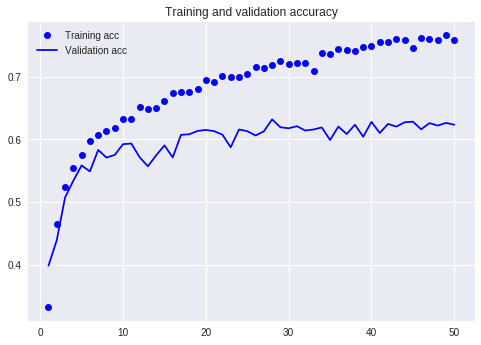

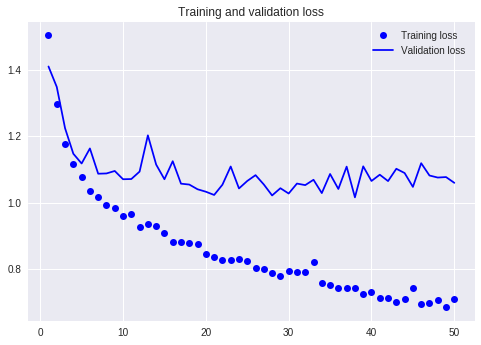

In [0]:
plot_train_history(accuracies5, losses5)

             precision    recall  f1-score   support

      Angry       0.76      0.32      0.45       467
      Happy       0.75      0.81      0.78       895
        Sad       0.47      0.57      0.51       653
   Surprise       0.69      0.80      0.74       415
    Neutral       0.52      0.52      0.52       607

avg / total       0.64      0.62      0.62      3037



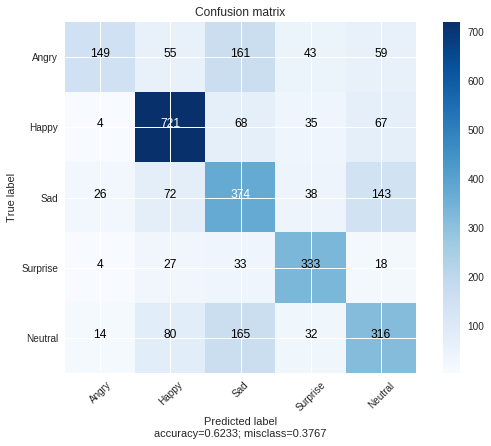

In [0]:
labels_ = [0, 1, 2, 3, 4]
target_names = ['Angry', 'Happy', 'Sad', 'Surprise', 'Neutral']
evaluate_model(model=model5, data=dataloaders_new['val'], labels_=labels_, target_names=target_names)

In [0]:
PATH_TMP = '/content/gdrive/My Drive/Face_detection/phase_1'
torch.save(model5.state_dict(), os.path.join(PATH_TMP, 'model5.pth'))


### 5. Feature maps visualization

In [0]:
class CamExtractor:
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
    
    def save_gradient(self, grad):
        self.gradients = grad
    
    def forward_pass_on_convolutions(self, x):
        conv_output = None
        for module_name, module in self.model._modules.items():
            print(module_name)
            if module_name == 'fc1':
                x = x.view(-1, x.size()[1])
            if module_name == 'fc3':
                return conv_output, x
            x = module(x) # forward pass
            if module_name == self.target_layer:
                print('OK')
                x.register_hook(self.save_gradient)
                conv_output = x
        
        return conv_output, x
    
    def forward_pass(self, x):
        conv_output, x = self.forward_pass_on_convolutions(x)
        # x = x.view(x.size(0), -1)
        x = self.model.fc3(x)
        return conv_output, x

class GradCam:
    
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)
    
    def generate_cam(self, input_image, target_index=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_index == None:
            target_index = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(device)
        one_hot_output[0][target_index] = 1
        self.model.fc3.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        target = conv_output.data.cpu().numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))

        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        print(cam.shape)
        cam = cv2.resize(cam, (48, 48))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam = np.uint8(cam * 255)
        return cam
            
        
def save_class_activation_on_image(org_img, activation_map, file_name):
    cv2.imwrite(os.path.join(PATH_TMP, file_name+'_Cam_Grayscale.jpg'),
               activation_map)
    
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    cv2.imwrite(os.path.join(PATH_TMP, file_name+'_Cam_Heatmap.jpg'),
               activation_heatmap)
    
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    cv2.imwrite(os.path.join(PATH_TMP, file_name+'_Cam_On_Image.jpg'),
               np.uint8(255 * img_with_heatmap))

def preprocess_image(np_image):
    image = np.expand_dims(np_image, 0)
    image = torch.from_numpy(image).float()
    image.unsqueeze_(0)
    return image

In [0]:
def save_class_activation_on_image(org_img, activation_map, file_name):
    # cv2.imwrite(os.path.join(PATH_TMP, file_name+'_Cam_Grayscale.jpg'),
    #           activation_map)
    
    return cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    

In [0]:
tmp_image = preprocess_image(fer2013_transformed[187])
tmp_image = tmp_image.to(device)

In [0]:
grad_cam = GradCam(model5, target_layer='conv8')

In [0]:
print(tmp_image.size())

torch.Size([1, 1, 48, 48])


In [0]:
cam = grad_cam.generate_cam(tmp_image, 1)

conv1
batchnorm1
conv2
batchnorm2
conv3
batchnorm3
conv4
batchnorm4
conv5
batchnorm5
conv6
batchnorm6
conv7
batchnorm7
conv8
OK
batchnorm8
avg_pool
fc1
batchnorm9
fc2
batchnorm10
fc3
(32, 32)


In [0]:
heatmap = save_class_activation_on_image(jaffe_transformed[10], cam, 'happy_1')

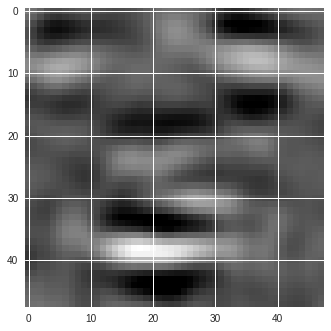

In [0]:
plt.imshow(cam, cmap='gray')

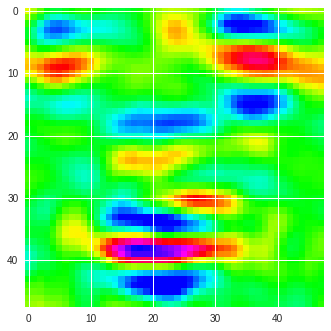

In [0]:
plt.imshow(heatmap)

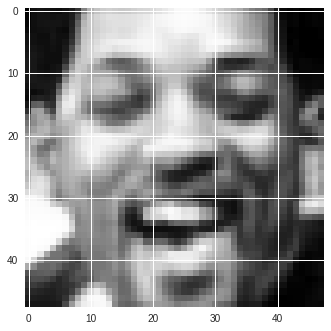

In [0]:
plt.imshow(fer2013_transformed[187], cmap='gray')

### 6. Using 224 x 224 image data

In [0]:
%%time
fer2013_train = fer2013_array[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='Training'))[0]]
fer2013_test = fer2013_array[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='PrivateTest'))[0]]
fer2013_val = fer2013_array[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='PublicTest'))[0]]

new_labels = {0: 0, 3: 1, 4: 2, 5: 3, 6: 4}

fer2013_train_labels = np.array([new_labels[item] 
                                 for item in 
                                 fer2013_labels[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='Training'))[0]]])
fer2013_test_labels = np.array([new_labels[item] 
                                 for item in 
                                 fer2013_labels[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='PrivateTest'))[0]]])
fer2013_val_labels = np.array([new_labels[item] 
                                 for item in 
                                 fer2013_labels[np.where((fer2013_labels!=1) & (fer2013_labels!=2) & (flags=='PublicTest'))[0]]])

jaffe_train = jaffe_array[np.where((jaffe_labels!=1) & (jaffe_labels!=2))[0]]
jaffe_train_labels = np.array([new_labels[item] 
                                 for item in 
                                 jaffe_labels[np.where((jaffe_labels!=1) & (jaffe_labels!=2))[0]]])


CPU times: user 206 ms, sys: 196 ms, total: 402 ms
Wall time: 404 ms


In [0]:
%%time
# get the data in dictionary 
training_data_dict = {}
training_data_jaffe_dict = {}
test_data_dict = {}
val_data_dict = {}

for i in range(5):
    training_data_dict[i] = fer2013_train[np.where(fer2013_train_labels==i)]
    training_data_jaffe_dict[i] = jaffe_train[np.where(jaffe_train_labels==i)]
    test_data_dict[i] = fer2013_test[np.where(fer2013_test_labels==i)]
    val_data_dict[i] = fer2013_val[np.where(fer2013_val_labels==i)]
    

CPU times: user 184 ms, sys: 229 ms, total: 413 ms
Wall time: 417 ms


In [0]:
for i in range(5):
    print("------Class {} --------".format(i))
    print(training_data_dict[i].shape)
    print(training_data_jaffe_dict[i].shape)
    print(test_data_dict[i].shape)
    print(val_data_dict[i].shape)

------Class 0 --------
(3995, 48, 48)
(30, 256, 256)
(491, 48, 48)
(467, 48, 48)
------Class 1 --------
(7215, 48, 48)
(31, 256, 256)
(879, 48, 48)
(895, 48, 48)
------Class 2 --------
(4830, 48, 48)
(31, 256, 256)
(594, 48, 48)
(653, 48, 48)
------Class 3 --------
(3171, 48, 48)
(30, 256, 256)
(416, 48, 48)
(415, 48, 48)
------Class 4 --------
(4965, 48, 48)
(30, 256, 256)
(626, 48, 48)
(607, 48, 48)


In [0]:
# download the pretrained face_detector file for dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P /content/data
!bzip2 -dk /content/data/shape_predictor_68_face_landmarks.dat.bz2

--2018-10-24 15:54:18--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/data/shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  51.6MB/s    in 1.2s    

2018-10-24 15:54:19 (51.6 MB/s) - ‘/content/data/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [0]:
PATH_DETECTOR = '/content/data/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PATH_DETECTOR)

In [0]:
# Instanciate a face aligner object
fa = FaceAligner(predictor, desiredFaceWidth=256)

# function to process one image
def align_and_crop_one_new(im):

    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # detect the face in the image
    rects = detector(gray, 2)
    if len(rects) > 0: # if we have at least one face detected
        rects = rects[0] # consider the 1st face
        faceAligned = fa.align(im, gray, rects) # align the face

        # cropping the image
        gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        rects = detector(faceAligned, 2)
        if len(rects) > 0:
            rects = rects[0]
            
            (x, y, w, h) = rect_to_bb(rects) # get the bounding box coordinates
            
            faceCropped = transform.resize(faceAligned[y: y + h, 
                                                 x: x + w, 0], (224, 224))

            return (exposure.equalize_hist(faceCropped), 'OK1')
        else:
            # if no face is found in the aligned face, return just a resized aligned face 48x48
            return (exposure.equalize_hist(transform.resize(faceAligned[:, :, 0], (224, 224))), 'OK2')
    else:
        # if no face is found at all in the image, return the resized original image 48x48
        return (exposure.equalize_hist(transform.resize(im[:, :, 0], (224, 224))), 'OK3')


# function to align faces and compute landmarks
def align_and_crop_new(list_images, class_, name):
    
    # converting image to 8-bit
    print('--------------Converting images----------------')
    list_images = list(np.uint8(list_images))
    
    #resizing the  images
    print('--------------Resizing images----------------')
    list_images = [np.repeat(np.expand_dims(im, 2), 3, 2) 
                       for im in list_images]
    
    print('--------------Align and Crop----------------')
    with Pool() as p:
        results_tuple = p.map(align_and_crop_one_new, tqdm.tqdm(list_images))
    
    results1 = [item[0] for item in results_tuple]
    results2 = [item[1] for item in results_tuple]
    
    # apply histogram equalization to all images and return the result
    results1 = np.concatenate([np.expand_dims(item, 0) for item in results1])
    
    # save the processed images
    path = os.path.join('/content/data/', name+'_'+str(class_)+'.npy')
    np.save(path, results1)
    
    return dict(Counter(results2))


In [0]:
%%time
counts_j = {}
for i in range(5):
    print('***********Processing class {}********'.format(i))
    counts_j[i] = align_and_crop_new(training_data_jaffe_dict[i], i, 'jaffe_train')

***********Processing class 0********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


***********Processing class 1********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 31/31 [00:08<00:00,  3.65it/s]


***********Processing class 2********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


***********Processing class 3********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


***********Processing class 4********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


CPU times: user 402 ms, sys: 1.05 s, total: 1.45 s
Wall time: 55.8 s


In [0]:
%%time
counts_test = {}
for i in range(5):
    print('***********Processing class {}********'.format(i))
    counts_test[i] = align_and_crop_new(test_data_dict[i], i, 'fer2013_test')

***********Processing class 0********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 491/491 [00:59<00:00,  8.26it/s]


***********Processing class 1********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 879/879 [01:59<00:00,  7.33it/s]


***********Processing class 2********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 594/594 [00:55<00:00, 10.74it/s]


***********Processing class 3********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 416/416 [00:54<00:00,  7.17it/s]


***********Processing class 4********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 626/626 [01:18<00:00,  8.02it/s]


CPU times: user 1.93 s, sys: 5.76 s, total: 7.69 s
Wall time: 8min 18s


In [0]:
%%time
counts_val = {}
for i in range(5):
    print('***********Processing class {}********'.format(i))
    counts_val[i] = align_and_crop_new(val_data_dict[i], i, 'fer2013_val')
    

***********Processing class 0********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 467/467 [00:56<00:00,  8.32it/s]


***********Processing class 1********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 895/895 [02:01<00:00,  7.36it/s]


***********Processing class 2********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 653/653 [01:05<00:00, 10.04it/s]


***********Processing class 3********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 415/415 [00:49<00:00,  8.39it/s]


***********Processing class 4********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 607/607 [01:18<00:00,  7.74it/s]


CPU times: user 1.99 s, sys: 5.89 s, total: 7.88 s
Wall time: 8min 26s


In [0]:
%%time
!cp /content/data/*.npy /content/gdrive/My\ Drive/Face_detection/data_224

CPU times: user 206 ms, sys: 139 ms, total: 345 ms
Wall time: 33.8 s


In [0]:
%%time
counts_train = {}
for i in range(5):
    print('***********Processing class {}********'.format(i))
    counts_train[i] = align_and_crop_new(training_data_dict[i], i, 'fer2013_train')
    

***********Processing class 0********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 3995/3995 [09:52<00:00,  6.74it/s]


***********Processing class 1********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 7215/7215 [18:24<00:00,  6.53it/s]


***********Processing class 2********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 4830/4830 [12:00<00:00,  6.71it/s]


***********Processing class 3********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 3171/3171 [06:42<00:00,  7.88it/s]


***********Processing class 4********
--------------Converting images----------------
--------------Resizing images----------------
--------------Align and Crop----------------


100%|██████████| 4965/4965 [10:43<00:00,  7.72it/s]


CPU times: user 15.1 s, sys: 2min 16s, total: 2min 31s
Wall time: 1h 24min 50s


In [0]:
dirs = ['train', 'val', 'test']
classes = ['0', '1', '2', '3', '4']
p_drive = '/content/gdrive/My Drive/Face_detection/data_224/'
for d in dirs:
    for cl in classes:
        if not os.path.exists(os.path.join(p_drive, d)):
            os.mkdir(os.path.join(p_drive, d))
        if not os.path.exists(os.path.join(os.path.join(p_drive, d), cl)):
            os.mkdir(os.path.join(os.path.join(p_drive, d), cl))

In [0]:
def save_as_image(paths):
    data = []
    for p in paths:
        data.append(np.load(p))
    cl = paths[0].split('_')[-1][:-4]
    d = paths[0].split('_')[-2]
    data = np.concatenate(data)
    
    for i, im in tqdm.tqdm(enumerate(data)):
        plt.imsave(arr=im, fname=os.path.join(p_drive, d, cl, str(i)+'.png'), cmap='gray')

In [0]:
list_paths = sorted(glob.glob('/content/data/*.npy'))
list_paths_test_val = [[p] for p in list_paths if 'train' not in p]
list_paths_train = [[p1, p2] 
                    for p1, p2 in zip([p for p in list_paths if 'fer2013_train' in p],
                                     [p for p in list_paths if 'jaffe_train' in p])]
print(list_paths_train)
print(list_paths_test_val)

[['/content/data/fer2013_train_0.npy', '/content/data/jaffe_train_0.npy'], ['/content/data/fer2013_train_1.npy', '/content/data/jaffe_train_1.npy'], ['/content/data/fer2013_train_2.npy', '/content/data/jaffe_train_2.npy'], ['/content/data/fer2013_train_3.npy', '/content/data/jaffe_train_3.npy'], ['/content/data/fer2013_train_4.npy', '/content/data/jaffe_train_4.npy']]
[['/content/data/fer2013_test_0.npy'], ['/content/data/fer2013_test_1.npy'], ['/content/data/fer2013_test_2.npy'], ['/content/data/fer2013_test_3.npy'], ['/content/data/fer2013_test_4.npy'], ['/content/data/fer2013_val_0.npy'], ['/content/data/fer2013_val_1.npy'], ['/content/data/fer2013_val_2.npy'], ['/content/data/fer2013_val_3.npy'], ['/content/data/fer2013_val_4.npy']]


In [0]:
for i, p in enumerate(list_paths_train):
    print('Saving class {}'.format(i))
    save_as_image(p)

Saving class 0


4025it [02:01, 33.00it/s]


Saving class 1


7246it [03:27, 34.87it/s]


Saving class 2


4861it [02:09, 37.64it/s]


Saving class 3


3201it [01:30, 27.42it/s]


Saving class 4


4995it [02:22, 35.15it/s]


In [0]:
for p in list_paths_test_val:
    print('*******{}*******'.format(p))
    save_as_image(p)

*******['/content/data/fer2013_test_0.npy']*******


491it [00:11, 42.31it/s]


*******['/content/data/fer2013_test_1.npy']*******


879it [00:21, 41.28it/s]


*******['/content/data/fer2013_test_2.npy']*******


594it [00:14, 41.93it/s]


*******['/content/data/fer2013_test_3.npy']*******


416it [00:09, 42.85it/s]


*******['/content/data/fer2013_test_4.npy']*******


626it [00:14, 42.17it/s]


*******['/content/data/fer2013_val_0.npy']*******


467it [00:11, 41.15it/s]


*******['/content/data/fer2013_val_1.npy']*******


895it [00:22, 38.84it/s]


*******['/content/data/fer2013_val_2.npy']*******


653it [00:18, 34.86it/s]


*******['/content/data/fer2013_val_3.npy']*******


415it [00:11, 35.70it/s]


*******['/content/data/fer2013_val_4.npy']*******


607it [00:17, 37.44it/s]


In [0]:
list_paths

['/content/data/fer2013_test_0.npy',
 '/content/data/fer2013_test_1.npy',
 '/content/data/fer2013_test_2.npy',
 '/content/data/fer2013_test_3.npy',
 '/content/data/fer2013_test_4.npy',
 '/content/data/fer2013_train_0.npy',
 '/content/data/fer2013_train_1.npy',
 '/content/data/fer2013_train_2.npy',
 '/content/data/fer2013_train_3.npy',
 '/content/data/fer2013_train_4.npy',
 '/content/data/fer2013_val_0.npy',
 '/content/data/fer2013_val_1.npy',
 '/content/data/fer2013_val_2.npy',
 '/content/data/fer2013_val_3.npy',
 '/content/data/fer2013_val_4.npy',
 '/content/data/jaffe_train_0.npy',
 '/content/data/jaffe_train_1.npy',
 '/content/data/jaffe_train_2.npy',
 '/content/data/jaffe_train_3.npy',
 '/content/data/jaffe_train_4.npy']

In [0]:
tmp2 = np.concatenate([tmp])

In [0]:
tmp2 == tmp

array([[[ True,  True],
        [ True,  True]]])

In [0]:
! du -ah /content/data/*train*

1.5G	/content/data/fer2013_train_0.npy
2.7G	/content/data/fer2013_train_1.npy
1.9G	/content/data/fer2013_train_2.npy
1.2G	/content/data/fer2013_train_3.npy
1.9G	/content/data/fer2013_train_4.npy
12M	/content/data/jaffe_train_0.npy
12M	/content/data/jaffe_train_1.npy
12M	/content/data/jaffe_train_2.npy
12M	/content/data/jaffe_train_3.npy
12M	/content/data/jaffe_train_4.npy


In [0]:
1.5+2.75+1.9+1.2+1.9

9.25

In [0]:
!ls /content/data

fer2013_test_0.npy   fer2013_val_1.npy
fer2013_test_1.npy   fer2013_val_2.npy
fer2013_test_2.npy   fer2013_val_3.npy
fer2013_test_3.npy   fer2013_val_4.npy
fer2013_test_4.npy   jaffe_train_0.npy
fer2013_train_0.npy  jaffe_train_1.npy
fer2013_train_1.npy  jaffe_train_2.npy
fer2013_train_2.npy  jaffe_train_3.npy
fer2013_train_3.npy  jaffe_train_4.npy
fer2013_train_4.npy  shape_predictor_68_face_landmarks.dat
fer2013_val_0.npy    shape_predictor_68_face_landmarks.dat.bz2


In [0]:
print(counts_val)
print(counts_test)

{0: {'OK1': 310, 'OK3': 150, 'OK2': 7}, 1: {'OK1': 669, 'OK3': 210, 'OK2': 16}, 2: {'OK1': 368, 'OK3': 276, 'OK2': 9}, 3: {'OK3': 110, 'OK1': 296, 'OK2': 9}, 4: {'OK1': 446, 'OK3': 149, 'OK2': 12}}
{0: {'OK1': 327, 'OK3': 151, 'OK2': 13}, 1: {'OK3': 184, 'OK1': 688, 'OK2': 7}, 2: {'OK1': 300, 'OK3': 277, 'OK2': 17}, 3: {'OK3': 111, 'OK1': 302, 'OK2': 3}, 4: {'OK1': 469, 'OK3': 153, 'OK2': 4}}


In [0]:
%%time
fer2013_transformed, counts = align_and_crop_new(fer2013_array)
jaffe_transformed, counts_j = align_and_crop_new(jaffe_array)

--------------Converting images----------------
--------------Resizing images----------------


100%|██████████| 35887/35887 [1:10:37<00:00,  8.47it/s]


In [0]:
fer

In [0]:
tmp_image = np.repeat(np.expand_dims(fer2013_array[2], 2), 3, 2).astype(np.uint8)

In [0]:
tmp_image2, ok = align_and_crop_one_new(tmp_image)

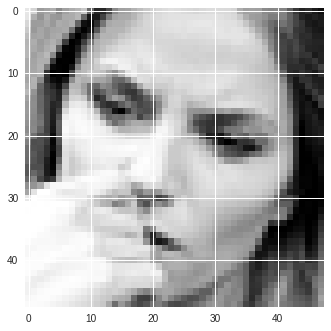

In [0]:
plt.imshow(tmp_image, cmap='gray')

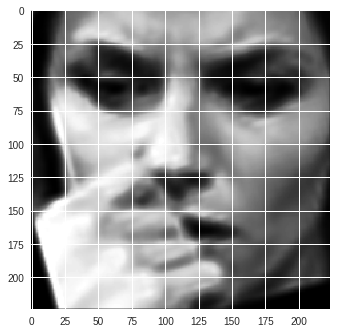

In [0]:
plt.imshow(tmp_image2, cmap='gray')

In [0]:
# loading data


###  5. Transfert learning 

#### 5.1 ResNet18

In [0]:
# load the model
resnet18 = models.resnet18(pretrained=True)

In [0]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
class ModelTest(torch.nn.Module):
    
    def __init__(self, dropout=0.3):
        super(ModelTest, self).__init__()
        
        self.dropout = dropout
        
        # 1st block
        self.conv1 = SeparableConv(1, 64)
        self.batchnorm1 = torch.nn.BatchNorm2d(64)
        self.conv2 = SeparableConv(64, 64)
        self.batchnorm2 = torch.nn.BatchNorm2d(64)
        
        # 2nd block
        self.conv3 = SeparableConv(64, 128)
        self.batchnorm3 = torch.nn.BatchNorm2d(128)
        self.conv4 = SeparableConv(128, 128)
        self.batchnorm4 = torch.nn.BatchNorm2d(128)
        
        # 3rd block
        self.conv5 = SeparableConv(128, 256)
        self.batchnorm5 = torch.nn.BatchNorm2d(256)
        self.conv6 = SeparableConv(256, 256)
        self.batchnorm6 = torch.nn.BatchNorm2d(256)
        
        # 4th block
        self.conv7 = SeparableConv(256, 512)
        self.batchnorm7 = torch.nn.BatchNorm2d(512)
        self.conv8 = SeparableConv(512, 512)
        self.batchnorm8 = torch.nn.BatchNorm2d(512)
        
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        # 1st fc block
        self.fc1 = torch.nn.Linear(512, 7)

        
    def forward(self, x):
        #1st block
        x = self.conv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        x = F.max_pool2d(x, 2)
        
        # 2nd block
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        x = F.max_pool2d(x, 2)
        
        # 3rd block
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        x = self.conv6(x)
        x = F.relu(self.batchnorm6(x))
        # x = F.max_pool2d(x, 2)
                
        # 4th block
        x = self.conv7(x)
        x = F.relu(self.batchnorm7(x))
        x = self.conv8(x)
        x = F.relu(self.batchnorm8(x))
        # x = F.max_pool2d(x, 2)
        
        x = self.avg_pool(x)
        x = x.view(-1, x.size()[1])
        x = self.fc1(x)
        
        return x


In [0]:
# instantiate model and optimizers
model5 = ModelTest()
model5 = model5.to(device)
criterion5 = torch.nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model5.parameters())


In [0]:
model5, accuracies5, losses5 = train_model(model5, criterion5, optimizer5, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.4320, Acc: 0.4426
val Loss: 1.3934, Acc: 0.4620

Epoch 2/50
----------
train Loss: 1.1985, Acc: 0.5393
val Loss: 1.3457, Acc: 0.4907

Epoch 3/50
----------
train Loss: 1.0684, Acc: 0.5938
val Loss: 1.2463, Acc: 0.5391

Epoch 4/50
----------
train Loss: 0.9411, Acc: 0.6461
val Loss: 1.2636, Acc: 0.5386

Epoch 5/50
----------
train Loss: 0.8067, Acc: 0.7002
val Loss: 1.3028, Acc: 0.5428

Epoch 6/50
----------
train Loss: 0.6722, Acc: 0.7498
val Loss: 1.4014, Acc: 0.5305

Epoch 7/50
----------
train Loss: 0.5382, Acc: 0.8024
val Loss: 1.5443, Acc: 0.5305

Epoch 8/50
----------
train Loss: 0.4222, Acc: 0.8480
val Loss: 1.6808, Acc: 0.5375

Epoch 9/50
----------
train Loss: 0.3384, Acc: 0.8780
val Loss: 1.8814, Acc: 0.5341

Epoch 10/50
----------
train Loss: 0.2867, Acc: 0.8980
val Loss: 1.9732, Acc: 0.5389

Epoch 11/50
----------
train Loss: 0.2374, Acc: 0.9171
val Loss: 2.1391, Acc: 0.5305

Epoch 12/50
----------
train Loss: 0.2042, Acc: 0.9281
val Loss